# Corridor width and position


Load libraries etc.:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()

import sys
sys.path.append('../simulations/')
from grid_manager import Grid
from habitat_analysis import HabitatAnalysis



## Landscape simulation function:

In [2]:
def perm_wall_sim(grid_shape = [30,60], Q=1, A=0.9, ww=3, wp=0.5, cw=[3,3], cp=[0.35,0.7]):
    "simulate a permeable wall"
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    qualities = np.ones((N,))*Q
    if type(A) in [float, int]:
        g = Grid(shape=grid_shape, qualities=qualities)
        g.A = A * g.A
    elif type(A) is ss.csr_matrix:
        g = Grid(shape=grid_shape, qualities=qualities, graph=A)
 
    # 2. compute the wall
    if ww>0:
        wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
        xs = range(wpt, wpt+ww)

        # 3. compute the corridors
        for i in range(len(cw)):
            cpt=int(math.floor(n_rows*cp[i])-math.ceil(cw[i]/2))
            if i == 0:
                ys = range(cpt)
            else:
                ys=ys+range(max(ys)+1+cw[i-1], cpt)
        ys=ys+range(max(ys)+1+cw[i], n_rows)

        impossible_nodes = list(itertools.product(ys,xs))
        g.set_impossible_nodes(impossible_nodes, impossible_affinity=9e-11)
    return g

## Make the figure:

In [3]:
#create the landscapes

wp=0.25
gs = []
lg25 = []
lg25.append(perm_wall_sim(ww=0))
lg25.append(perm_wall_sim(wp=wp, cw=[0], cp=[0.5]))
lg25.append(perm_wall_sim(wp=wp, cw=[1,0], cp=[0.35,0.7]))
lg25.append(perm_wall_sim(wp=wp, cw=[4,0], cp=[0.35,0.7]))
lg25.append(perm_wall_sim(wp=wp, cw=[4,1], cp=[0.35,0.7]))
lg25.append(perm_wall_sim(wp=wp, cw=[4,4], cp=[0.35,0.7]))

wp=0.5
lg50 = []
lg50.append(perm_wall_sim(ww=0))
lg50.append(perm_wall_sim(wp=wp, cw=[0], cp=[0.5]))
lg50.append(perm_wall_sim(wp=wp, cw=[1,0], cp=[0.35,0.7]))
lg50.append(perm_wall_sim(wp=wp, cw=[4,0], cp=[0.35,0.7]))
lg50.append(perm_wall_sim(wp=wp, cw=[4,1], cp=[0.35,0.7]))
lg50.append(perm_wall_sim(wp=wp, cw=[4,4], cp=[0.35,0.7]))

N = lg25[0].N

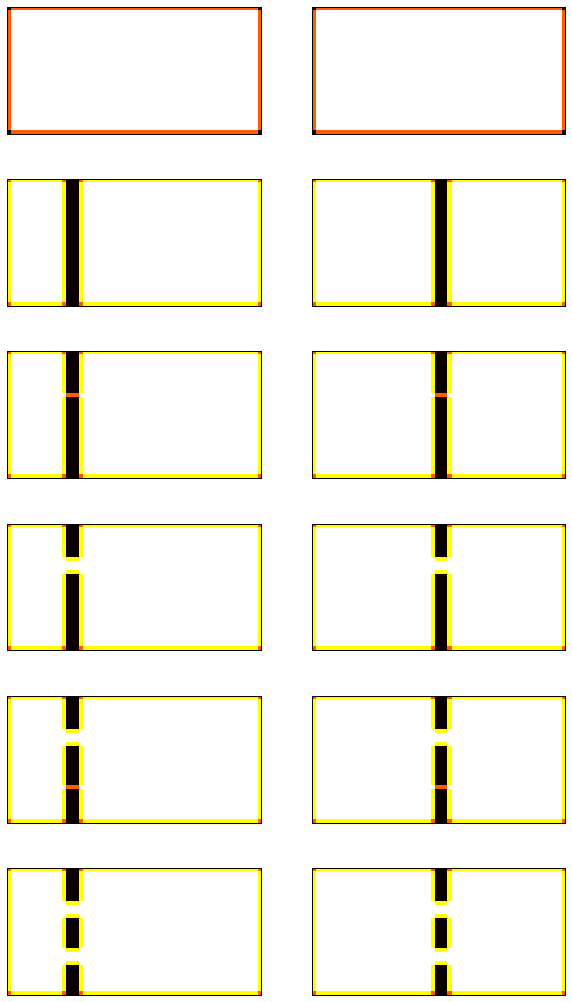

In [4]:
fig, ax = plt.subplots(6,2, figsize=(2*5,6*3))

for j in range(6):
    values = lg25[j].A.transpose().dot(np.ones((lg25[j].N, )))
    z = np.reshape(values, lg25[j].shape)
    ax[j,0].set_xticks([])
    ax[j,0].set_yticks([])
    ax[j,0].imshow(z, cmap='hot', interpolation='nearest')
    
    values = lg50[j].A.transpose().dot(np.ones((lg50[j].N, )))
    z = np.reshape(values, lg50[j].shape)
    ax[j,1].set_xticks([])
    ax[j,1].set_yticks([])
    ax[j,1].imshow(z, cmap='hot', interpolation='nearest')
    

In [5]:
#set the different parameters
beta1 = 3
beta2 = 0.1
a_to_c = 'minus_log'
d_to_k = 'exp_minus'

### Compute shortest path betweenness with NetworkX and plot

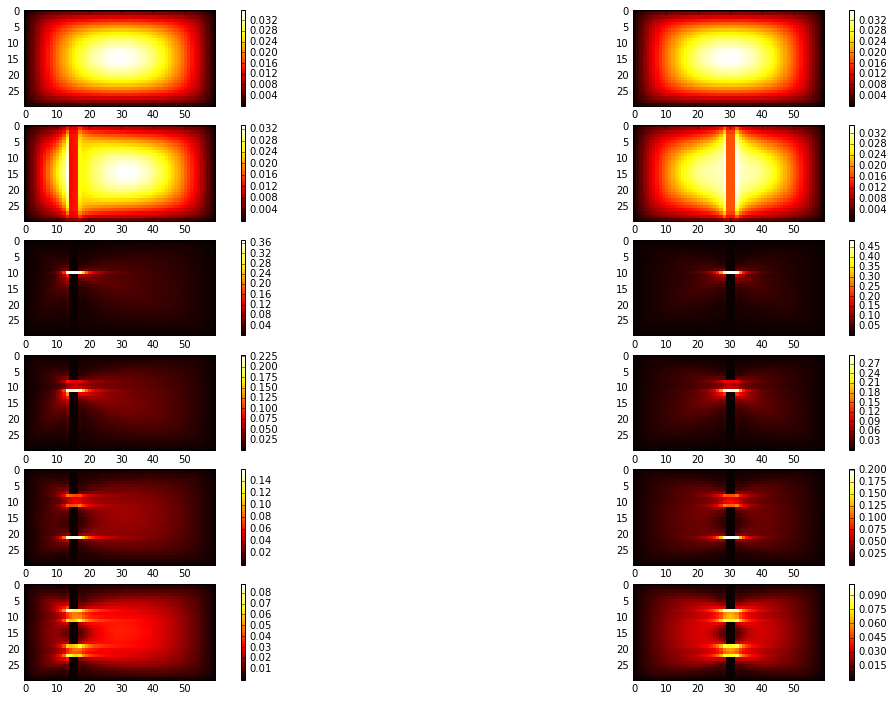

In [6]:
import networkx as nx
fig, axs = plt.subplots(6,2, figsize=(4*5,6*2))

for j,ax_row in enumerate(axs):
    i=-1
    for g in [lg25[j], lg50[j]]:
        i += 1
        l = HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                            similarity_measure='least_cost',\
                            affinity_to_cost=a_to_c, distance_to_similarity=d_to_k)
        l.compute_cost_matrix()
        G = nx.DiGraph(l.C)
        bet_dict = nx.betweenness_centrality(G,weight='weight')
        bet = [bet_dict[k] for k in xrange(N)]
        g.plot(bet, ax=ax_row[i])

### Compute RSP betweenness with two values of beta and plot:

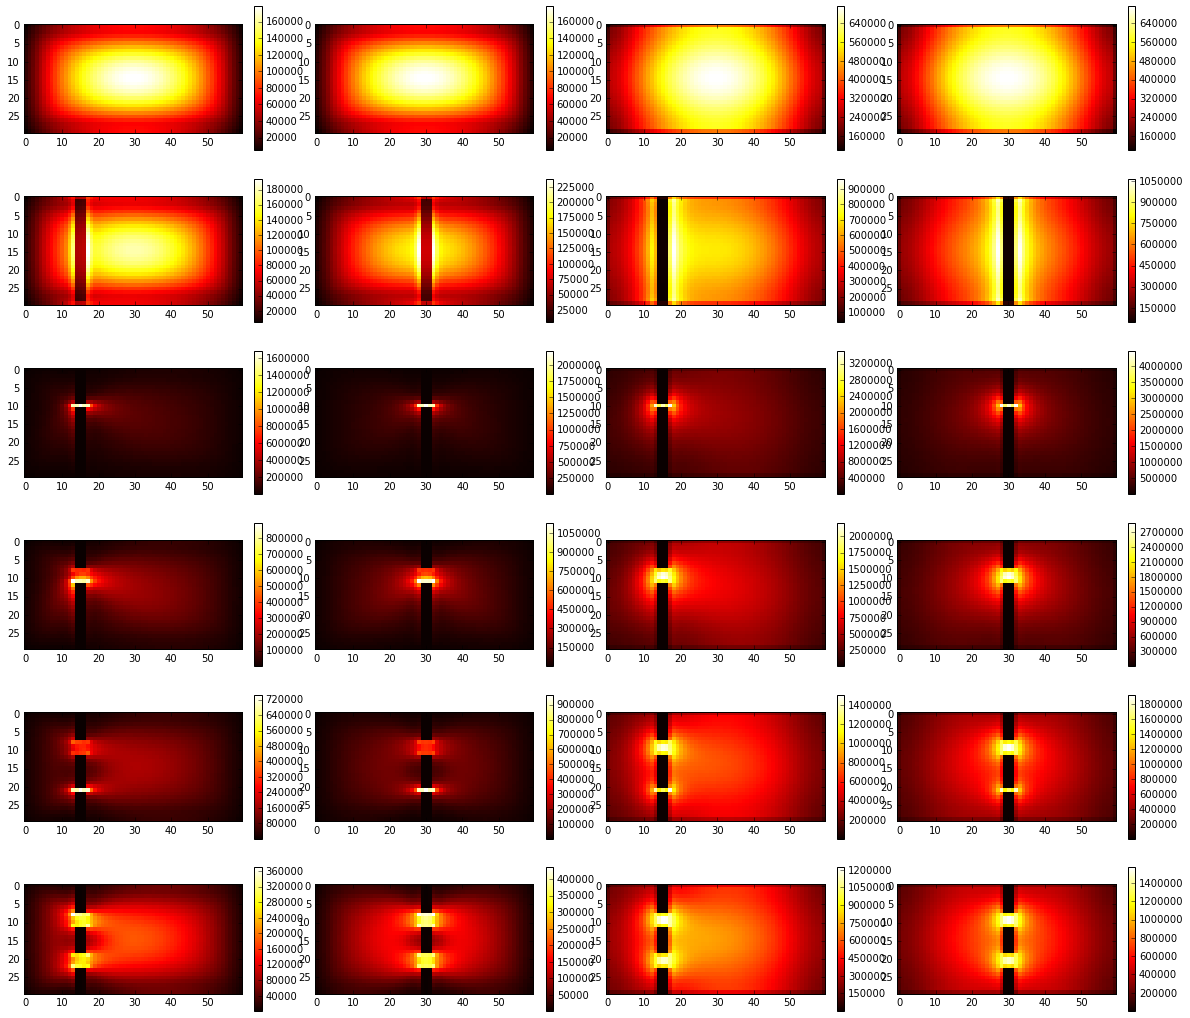

In [7]:
fig, axs = plt.subplots(6,4, figsize=(4*5,6*3))

for j,ax_row in enumerate(axs):
    i=-1
    for beta in [beta1, beta2]:
        for g in [lg25[j], lg50[j]]:
            i += 1
            landscape = \
            HabitatAnalysis(g, sampling_method='qualities', n_landmarks=N,\
                            similarity_measure='free_energy', beta=beta,\
                            affinity_to_cost=a_to_c, distance_to_similarity=d_to_k)
            g.plot(landscape.RSP_full_betweenness(), ax=ax_row[i])
